# Importações:

In [51]:
import os
from pyhdf.SD import SD, SDC
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize
from tqdm import tqdm

# Funções Utilizadas:

## Dados L2 VFM:

In [52]:
# Função que retorna dados das flags organizadas em arrays de 3 dimensões (lat x perfil x altitude)
def reshape_lpa(dado, lat):
    size = lat.shape[0] # pega tamanho do array contendo as latitudes
    # Aplicando a função reshape em cada intervalo dos dados de acordo com a resolução de cada faixa de altitude
    tipo = [np.flip(np.reshape(dado[:,1165:], (size, 15, 290)), 2)]
    tipo.append(np.flip(np.reshape(dado[:,165:1165], (size, 5, 200)), 2))
    return tipo # retorna lista de 3 elementos com arrays que foram organizados por faixa de altitude

In [53]:
def decoficando_bits(flags,lat):
    """
    Extrai tipo dos elementos e subtipo dos aerossóis, faz controle de qualidade e reformula array em latitude, 
    perfil e altitude de acordo com a resolução da faixa de altitude
    """
    # Extraindo elementos dos bits e faz controle de qualidade pelas flags de cq
    typesqa = (((flags>>3) & 3)>=2).astype('int')
    types =[(flags & 7) * typesqa] # lista com tipo do elemento dos 3 primeiros bits da flag extraido usando mascaramento de bits

    # Extrai subtipos aerossóis troposféricos e aerossóis estratosféricos dos bits e faz controle de qualidade pelas flags de cq
    subtypeqa = ((flags>>12) & 1)
    subtype = ((flags >> 9) & 7) * subtypeqa # extrai o subtipo do elementos dos 3 primeiros bits a esquerda da posição 9
    
    for tipo in range(3,5):
        tmask = (types[0] == tipo) # array de boleano indicando onde o tipo das flags é igual ao tipo do loop
        temp1 = (subtype!=0) # array de boleano indicando onde o subtipo das flags é diferente de 0
        temp2 = (temp1 & tmask) # array de boleano indicando onde o tipo das flags é igual ao tipo do loop e o subtipo é diferente de zero
        subtipo = subtype * temp2 # array que mantém apenas valores dos subtipos onde onde o tipo das flags é igual ao tipo do loop e o subtipo é diferente de zero
        types.append(subtipo) # adiciona lista types um array contendo os valores dos subtipos classificados de acordo com os tipos: nevem, aerossol troposférico e aerossol estratosférico respectivamente
    # Adiciona a cada classificação os valores de tipos e subtipos em array de 3 dimensões (lat x perfil x altitude)

    return [reshape_lpa(type,lat) for type in types]
    # return reshape_lpa(types[1],lat)

## Dados L3 VFM:

In [54]:
def idx_coord(lista_coor, coord):
    """ Função que retorna indice do valor da lista mais proximo ao valor passado """
    return (np.abs(lista_coor - (coord))).argmin()

In [55]:
def slice_variaveis(dados, lat_n, lat_s, lon_e, lon_w, variavel):
    """Retorna o valor da variável com corte de área a partir do HDF"""
    # Cria variaveis de lat e lon
    dado = dados.copy()
    lat = dado.select('Latitude_Midpoint').get()[0]
    lon = dado.select('Longitude_Midpoint').get()[0]

    # Selecionando índices correspondentes aos pontos mais proximos ao intervalo dado
    idx_n_lat, idx_s_lat = idx_coord(lat, lat_n), idx_coord(lat, lat_s)
    idx_e_lon, idx_w_lon = idx_coord(lon, lon_e), idx_coord(lon, lon_w)

    dado = dado.select(variavel)[int(idx_s_lat):int(idx_n_lat) + 1,
                                 int(idx_w_lon):int(idx_e_lon) + 1]
    dado = dado.astype('float')
    dado[dado == -9999] = np.nan
    if 'Extinction_Coefficient_532_Mean' in variavel:
        dado[dado < 0] = np.nan
        dado[dado > 4] = np.nan
    elif 'AOD_Mean' in variavel:
        dado[dado < 0] = np.nan
        dado[dado > 5] = np.nan
    else:
        dado[dado < 0] = np.nan
        dado[dado > 32767] = np.nan
    return dado

In [56]:
def porc_passou_qc(dados):
    dado = dados.copy()
    return (dado.size - np.count_nonzero(np.isnan(dado)))/dado.size

In [57]:
def med_espacial(dado):
    med_esp = np.nanmean(np.nanmean(dado, axis=0), axis=0)
    return med_esp

In [58]:
def med_estacao_det_tipo(dados):
    dado = dados.copy()
    det_tipo = pd.concat(dado, axis=1).T
    det_tipo.index.rename(['mês', 'tipo'], inplace=True)
    # Criando indice com estação e ano
    det_tipo['Estacão_ano'] = ['INVERNO ' + x[:4] if 6 <= int(x[-2:]) <= 8
                               else 'PRIMAVERA ' + x[:4] if 9 <= int(x[-2:]) <= 11
                               else 'VERÃO ' + str(int(x[:4]) + 1) if x[-2:] == '12'
                               else 'VERÃO ' + x[:4] if int(x[-2:]) <= 2
                               else 'OUTONO ' + x[:4] for x in det_tipo.index.get_level_values(0)]
    det_tipo = det_tipo.set_index('Estacão_ano', append=True)

    # Excluir estações dos anos que não tem 3 meses para compor a média sazonal
    unique, counts = np.unique(det_tipo.groupby(
        level=[0, 2]).count().index.get_level_values(1), return_counts=True)
    meses_est = dict(zip(unique, counts))
    excluir = [mes for mes in meses_est.keys() if meses_est[mes] < 3]
    det_tipo.drop(excluir, level=2, axis=0, inplace=True)
    # Fazendo a média sazonal para cada ano
    det_tipo = det_tipo.groupby(level=[2, 1]).mean()
    return det_tipo.loc[(det_tipo != 0).any(axis=1)]

In [59]:
def med_estacao_uni(dados):
    dado = dados.copy()
    # dado = pd.DataFrame.from_dict(dado, orient='index')

    dado['Estacão_ano'] = ['INVERNO ' + x[:4] if 6 <= int(x[-2:]) <= 8
                           else 'PRIMAVERA ' + x[:4] if 9 <= int(x[-2:]) <= 11
                           else 'VERÃO ' + str(int(x[:4]) + 1) if x[-2:] == '12'
                           else 'VERÃO ' + x[:4] if int(x[-2:]) <= 2
                           else 'OUTONO ' + x[:4] for x in dado.index]
    dado = dado.set_index('Estacão_ano')

    # Verificando quais estações de cada ano contam com os 3 meses para compor a média sazonal do ano
    unique, counts = np.unique(dado.index, return_counts=True)
    meses_est = dict(zip(unique, counts))
    excluir = [mes for mes in meses_est.keys() if meses_est[mes] < 3]
    # Removendo dados das estações que não tem 3 meses para a média
    dado.drop(excluir, axis=0, inplace=True)
    return dado.groupby(level=[0]).mean()

In [60]:
def med_periodo_uni(dados):
    dado = dados.copy()
    return dado.groupby([dado.index.get_level_values(0).str[:-5]]).agg(['mean', 'std']).stack()

In [61]:
def med_periodo_det_tipo(dados):
    dado = dados.copy()
    media = dado.groupby([dado.index.get_level_values(
        0).str[:-5], dado.index.get_level_values(1)]).agg(['mean', 'std']).stack()
    return media.loc[(media != 0).any(axis=1)]

In [62]:
def anomalia_estacao(med_est, media_per):
    media_per = media_per.reorder_levels([1, 0], axis=1)
    media_per = media_per['mean']
    for estacao in media_per.columns:
        med_est[[col for col in med_est.columns if estacao in col]] = med_est[[
            col for col in med_est.columns if estacao in col]].sub(media_per[estacao], axis=0)
    return med_est

In [63]:
def anomalia_tipos(med_est, media_per):
    anom_dict = {}
    estacoes = ['INVERNO', 'PRIMAVERA', 'VERÃO', 'OUTONO']
    media_per = media_per.reorder_levels([2, 0, 1], axis=1)
    media_per = media_per['mean']
    for estacao in estacoes:
        anom_dict[estacao] = med_est[[col for col in med_est.columns.unique(
            level=0) if estacao in col]].sub(media_per[estacao], axis=0)
    # return anom_dict
    return pd.concat(anom_dict, axis=1)

# Funções de Auxílio:

In [64]:
def fun_district(path):
    '''
        Não acho que seria interessante misturar os arquivos HDFs com outros arquivos,
    porém, do jeito que está configurada a minha organização das pastas, não há a necessidade
    de gerar outra entrada para dizer onde as imagens serão salvas.
    
        Essa função então, foi construida para cumprir esse propósito, a ideia aqui é
    reorganizar o caminho dos diretório para que as imagens sejam salvas de forma organizada.
    '''
    
    # Acrescentando um termo para gerar outro diretório:
    img_diretorio = path+'_img'
    
    # Caso a pasta não tenha sido criada previamente:
    if not os.path.exists(img_diretorio):
        os.mkdir(img_diretorio)
        
    return img_diretorio

In [65]:
def hdf_path(diretorio, faixa_ano=None):
    '''
    Retorna uma lista de caminhos para arquivos HDF que estão no diretório fornecido e na faixa de anos especificada.
    '''
    if faixa_ano is None:
        faixa_ano = []

    # Obter o ano inicial e o ano final da faixa de anos
    ano_inicial = min(faixa_ano) if faixa_ano else None
    ano_final = max(faixa_ano) if faixa_ano else None

    hdf_files = []
    for filename in os.listdir(diretorio):
        if filename.endswith(".hdf"):
            ano_local = int(filename[51:55])
            # Verificar se o ano do arquivo está dentro da faixa de anos
            if (ano_inicial is None or ano_local >= int(ano_inicial)) and (ano_final is None or ano_local <= int(ano_final)):
                hdf_path = os.path.join(diretorio, filename)
                hdf_files.append(hdf_path)   
    return hdf_files

# Importando Arquivos:

In [66]:
path = input('Digire o diretório completo contendo inclusive a pasta onde estão os arquivos:\n')
area = path[-1]
hdf_files = [os.path.join(path, filename) for filename in os.listdir(path) if filename.endswith(".hdf")]

Digire o diretório completo contendo inclusive a pasta onde estão os arquivos:
D:\Estudo\LASA\Dados\Mar\area1


In [67]:
cidade = input('Digite o nome da cidade: ')

if cidade == "":
    cidade = 'Bahia'
    print('valor defaut atribuido')

Digite o nome da cidade: mar


# Análise e Classifição de Elemento:

In [68]:
#Criando o dicionário
#Vendo de um em um (iterando) os arquivos
meses_ano = set()
# dados = {'elementos':{},'aero_tro':{},'aero_est':{}}
dados = {'elementos':{}, 'Aerossóis_Troposféricos':{}, 'Aerossóis_Estratosféricos':{}}
for file in hdf_files:
    arquivo = file.split('\\')[-1]
    meses_ano.add(arquivo[30:37])
    passagem = arquivo[30:-22]+' '+arquivo[-21:-19]+':'+arquivo[-18:-16]+':'+arquivo[-15:-12]
    hdf = SD(file,SDC.READ)
    flags = hdf.select('Feature_Classification_Flags')[:,:] # copiar as flags de classificação    
    lat = hdf.select('Latitude').get().flatten() # Copia valores de latitude de array com duas latitudes para array de uma dimensão
    classificacoes = decoficando_bits(flags,lat)
    for chave, classificacao in zip(dados.keys(), classificacoes):
        dados[chave][passagem] = classificacao

In [69]:
# Juntar arrays de detecções diáriária por lat x perfil x altitude em detecções mensais por área x altitude
# Lista com os meses
# passagens = dados['aero_tro'].keys()
passagens = dados['Aerossóis_Troposféricos'].keys()
classificacao_mensal = {}
for clasf in dados.keys():
    classificacao_mensal[clasf]={}
    for mes_ano in meses_ano:
        clasf_mes_0 = None  # Variável onde salvaremos um array com todas as classificações para todos as latitudes, perfis, dias por altura
        clasf_mes_1 = None  # Variável onde salvaremos um array com todas as classificações para todos as latitudes, perfis, dias por altura
        for passagem in passagens:
            if mes_ano == passagem[:7]:
                # Caso a variável de clasf_mes ainda esteja vazia
                if clasf_mes_0 is None:
                    clasf_mes_0 = dados[clasf][passagem][0].reshape(-1, dados[clasf][passagem][0].shape[-1])
                    clasf_mes_1 = dados[clasf][passagem][1].reshape(-1, dados[clasf][passagem][1].shape[-1])
                else:
                    clasf_mes_0 = np.vstack((clasf_mes_0, dados[clasf][passagem][0].reshape(-1, dados[clasf][passagem][0].shape[-1])))
                    clasf_mes_1 = np.vstack((clasf_mes_1, dados[clasf][passagem][1].reshape(-1, dados[clasf][passagem][1].shape[-1])))
        classificacao_mensal[clasf][mes_ano] = [clasf_mes_0, clasf_mes_1]

In [70]:
freq_total = {'Aerossóis_Troposféricos':{}, 'Aerossóis_Estratosféricos':{}}
for clasf in freq_total.keys():
    for mes_ano in meses_ano:
        freq_total[clasf][mes_ano] = [pd.DataFrame(np.count_nonzero(classificacao_mensal[clasf][mes_ano][0], axis=0), columns=[mes_ano])/classificacao_mensal[clasf][mes_ano][0].shape[0],
                    pd.DataFrame(np.count_nonzero(classificacao_mensal[clasf][mes_ano][1], axis=0), columns=[mes_ano])/classificacao_mensal[clasf][mes_ano][1].shape[0]]
        freq_total[clasf][mes_ano] = pd.concat(freq_total[clasf][mes_ano], axis=0, ignore_index=True)

    freq_total[clasf] = pd.concat(freq_total[clasf].values(), axis = 1)

In [71]:
# Calculando média sazonal por ano, sazonal por período e anomalia da detecção total dos aerossóis troposféricos
freq_total_med_estacao = med_estacao_uni(freq_total['Aerossóis_Troposféricos'].T)
freq_total_med_periodo = med_periodo_uni(freq_total_med_estacao)
anomalia_freq_total = anomalia_estacao(freq_total_med_estacao.T,freq_total_med_periodo.T)

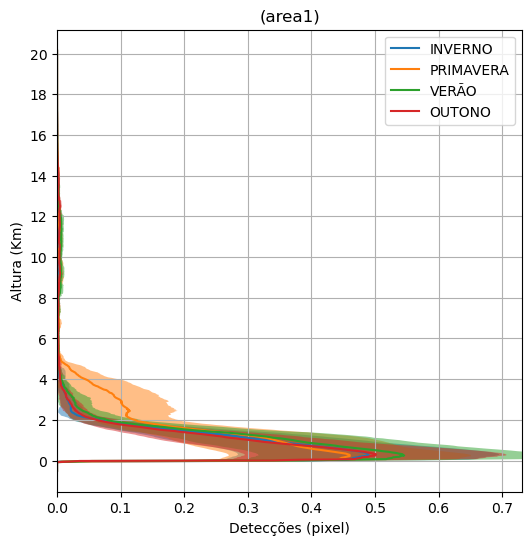


    Esse gráfico trata da frequência média de detecções de todos os tipos de aerossóis troposféricos.



In [72]:
# Perfil vertical do total de detecções de aerossóis troposféricos 
estacoes = ['INVERNO','PRIMAVERA','VERÃO','OUTONO']
alt_0_8 = [round(-0.5 + x*0.03, 2) for x in range(0,290)]
alt_8_20 = [round(8.2 + x*0.06, 2) for x in range(0,200)]
alt= alt_0_8+alt_8_20
fig, ax = plt.subplots(figsize = (6,6), facecolor='white')
for estacao in estacoes:
    ax.plot(freq_total_med_periodo.T[estacao, 'mean'],alt)
    ax.fill_betweenx( alt, freq_total_med_periodo.T[estacao, 'mean']+freq_total_med_periodo.T[estacao, 'std'],
    freq_total_med_periodo.T[estacao, 'mean']-freq_total_med_periodo.T[estacao, 'std'], alpha=0.5, label='_nolegend_')

    ax.set_xlabel('Detecções (pixel)', fontsize= 10)
    ax.set_ylabel('Altura (Km)',fontsize= 10)

    ax.set_xlim(0) 
    ax.set_yticks(np.arange(0,22, 2))
    ax.set_xticks(np.arange(0, .8, 0.1))
    ax.grid(True)
    
#plt.title('Média Sazonal - Total Aerossóis Troposféricos')
plt.title(f"(area{area})")
plt.legend(estacoes)
#fig.tight_layout()
#plt.savefig(fun_district(path) +'\\'+cidade + f'_media_sazonal_2006_2021_total_deteccoes(area{area})', bbox_inches='tight')
plt.show()

print('''
    Esse gráfico trata da frequência média de detecções de todos os tipos de aerossóis troposféricos.
''')

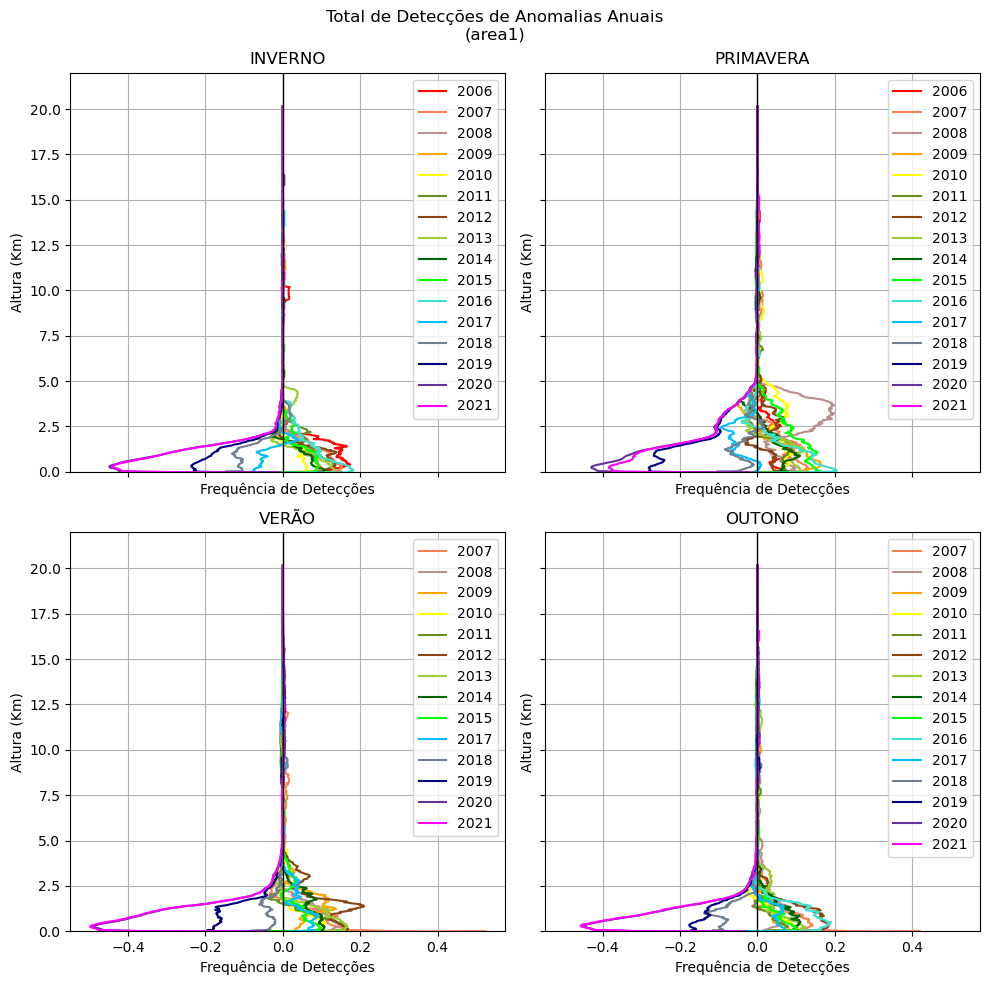


    Frequencia de detecções das anomalias anuais de todos os aressóis troposféricos de cada uma das estação em relação a média da própria estação. 
    
    Explicação da Beca:Anomalia sazonal anual das detecções de aerossóis troposféricos em relação a média sazonal de detecção de aerossóis troposféricos



In [73]:
cores = {'2006': 'red', '2007': 'coral', '2008': 'rosybrown', '2009': 'orange',
         '2010': 'yellow', '2011': 'olivedrab', '2012': 'saddlebrown', '2013': 'yellowgreen',
         '2014': 'darkgreen', '2015': 'lime', '2016': 'turquoise', '2017': 'deepskyblue',
         '2018': 'slategrey', '2019': 'navy', '2020': 'rebeccapurple', '2021': 'fuchsia',
         '2022': 'deeppink'}


estacoes = ['INVERNO', 'PRIMAVERA', 'VERÃO', 'OUTONO']


fig, axs = plt.subplots(2,2,figsize = (10,10), facecolor='white', sharex=True, sharey=True)
fig.suptitle(f'Total de Detecções de Anomalias Anuais\n(area{area})')
for estacao,ax in zip(estacoes,axs.flatten()):
    anos = anomalia_freq_total[[col for col in anomalia_freq_total.columns if estacao in col]].columns
    for ano in anos:
        ax.plot(anomalia_freq_total[ano], alt, color = cores[ano[-4:]])
    ax.legend([col[-4:] for col in anos if estacao in col])
    ax.set_title(estacao)
    ax.axvline(color = 'black',linewidth=1)
    ax.set_ylim(0,22)
    ax.grid(True)
    ax.set_ylabel('Altura (Km)',fontsize= 10)   
    ax.set_xlabel('Frequência de Detecções', fontsize= 10)

fig.tight_layout()
#plt.savefig(fun_district(path) +'\\'+ cidade + f'_anomalia_total_deteccoes(area{area})', bbox_inches='tight')
plt.show()
print('''
    Frequencia de detecções das anomalias anuais de todos os aressóis troposféricos de cada uma das estação em relação a média da própria estação. 
    
    Explicação da Beca:Anomalia sazonal anual das detecções de aerossóis troposféricos em relação a média sazonal de detecção de aerossóis troposféricos
''')

In [74]:
deteccoes = {}
frequencia_tipo = {}
for mes_ano in meses_ano:
    # Uma lista vazia para cada faixa de altitude onde serão incluidas as contagens para cada altura
    deteccoes[mes_ano] = [[], []]
    # Olhando cada faixa de altitude
    for fx_alt in range(len(classificacao_mensal['Aerossóis_Troposféricos'][mes_ano])):
        # print(classificacao_mensal['Aerossóis_Troposféricos'][mes_ano][fx_alt].shape)
        # Olhando o array de cada altitude
        for alt in range(len(classificacao_mensal['Aerossóis_Troposféricos'][mes_ano][fx_alt][0, :])):
            # Retorna valores únicos encontrados no array de cada altura e quantas sua contagem
            
            unique, counts = np.unique(
                classificacao_mensal['Aerossóis_Troposféricos'][mes_ano][fx_alt][:, alt], return_counts=True)
            # Adiciona a lista contagem de cada aerossol para cada altura
            deteccoes[mes_ano][fx_alt].append(dict(zip(unique, counts)))
 
        deteccoes[mes_ano][fx_alt] = pd.DataFrame(deteccoes[mes_ano][fx_alt])  # Transformando em df
        # Excluindo coluna 0 que corresponde a aerossóis não detectados
        deteccoes[mes_ano][fx_alt].drop(columns=[0], inplace=True) 
    # Dividindo o valor de detecções de cada aerossol do df pela quantidade de amostras em pixels para obter frequência
    frequencia_tipo[mes_ano] = [deteccoes[mes_ano][0]/classificacao_mensal['Aerossóis_Troposféricos'][mes_ano][0].shape[0],
                            deteccoes[mes_ano][1]/classificacao_mensal['Aerossóis_Troposféricos'][mes_ano][1].shape[0]]
    frequencia_tipo[mes_ano] = pd.concat(frequencia_tipo[mes_ano], ignore_index=True).fillna(0)
                            
    deteccoes[mes_ano] = pd.concat(deteccoes[mes_ano], ignore_index=True)
    
import collections
deteccoes = collections.OrderedDict(sorted(deteccoes.items()))
frequencia_tipo = collections.OrderedDict(sorted(frequencia_tipo.items()))

In [75]:
med_freq_estacao = med_estacao_det_tipo(frequencia_tipo)
med_freq_periodo = med_periodo_det_tipo(med_freq_estacao)
anomalia_freq = anomalia_tipos(med_freq_estacao.T, med_freq_periodo.T)

med_freq_periodo = med_freq_periodo.T.rename({1: 'Marinho Limpo', 2: 'Poeira', 3: 'Poluição Continental/Fumaça',
                                    4: 'Continental Limpo', 5: 'Poeira Poluída', 6: 'Fumaça Elevada', 7: 'Poeira Marinha'}, level=1, axis=1)
med_freq_estacao = med_freq_estacao.T.rename({1: 'Marinho Limpo', 2: 'Poeira', 3: 'Poluição Continental/Fumaça',
                                    4: 'Continental Limpo', 5: 'Poeira Poluída', 6: 'Fumaça Elevada', 7: 'Poeira Marinha'}, level=1, axis=1)
anomalia_freq = anomalia_freq.rename({1: 'Marinho Limpo', 2: 'Poeira', 3: 'Poluição Continental/Fumaça',
                            4: 'Continental Limpo', 5: 'Poeira Poluída', 6: 'Fumaça Elevada', 7: 'Poeira Marinha'}, level=2, axis=1)

In [76]:
med_estacao = med_estacao_det_tipo(deteccoes)
med_periodo = med_periodo_det_tipo(med_estacao)
anomalia = anomalia_tipos(med_estacao.T, med_periodo.T)
med_periodo = med_periodo.T.rename({1: 'Marinho Limpo', 2: 'Poeira', 3: 'Poluição Continental/Fumaça',
                                    4: 'Continental Limpo', 5: 'Poeira Poluída', 6: 'Fumaça Elevada', 7: 'Poeira Marinha'}, level=1, axis=1)
med_estacao = med_estacao.T.rename({1: 'Marinho Limpo', 2: 'Poeira', 3: 'Poluição Continental/Fumaça',
                                    4: 'Continental Limpo', 5: 'Poeira Poluída', 6: 'Fumaça Elevada', 7: 'Poeira Marinha'}, level=1, axis=1)
anomalia = anomalia.rename({1: 'Marinho Limpo', 2: 'Poeira', 3: 'Poluição Continental/Fumaça',
                            4: 'Continental Limpo', 5: 'Poeira Poluída', 6: 'Fumaça Elevada', 7: 'Poeira Marinha'}, level=2, axis=1)

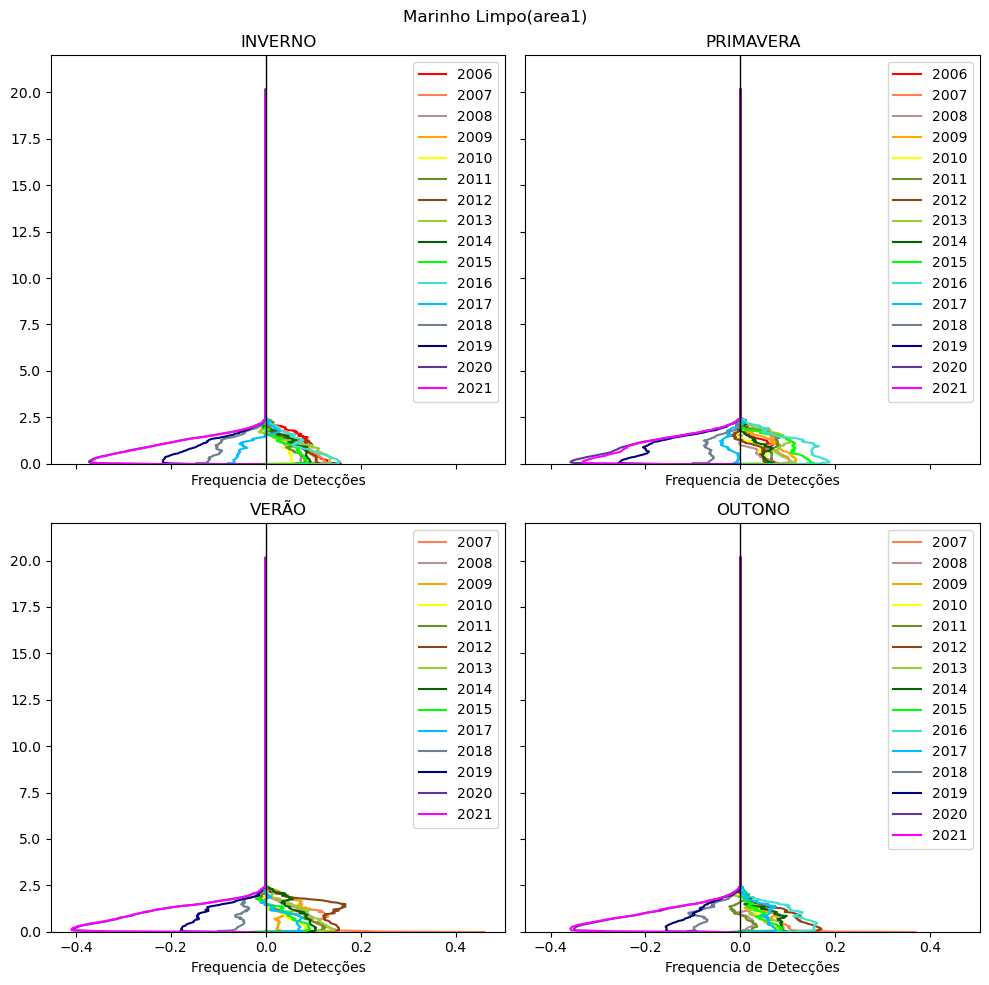

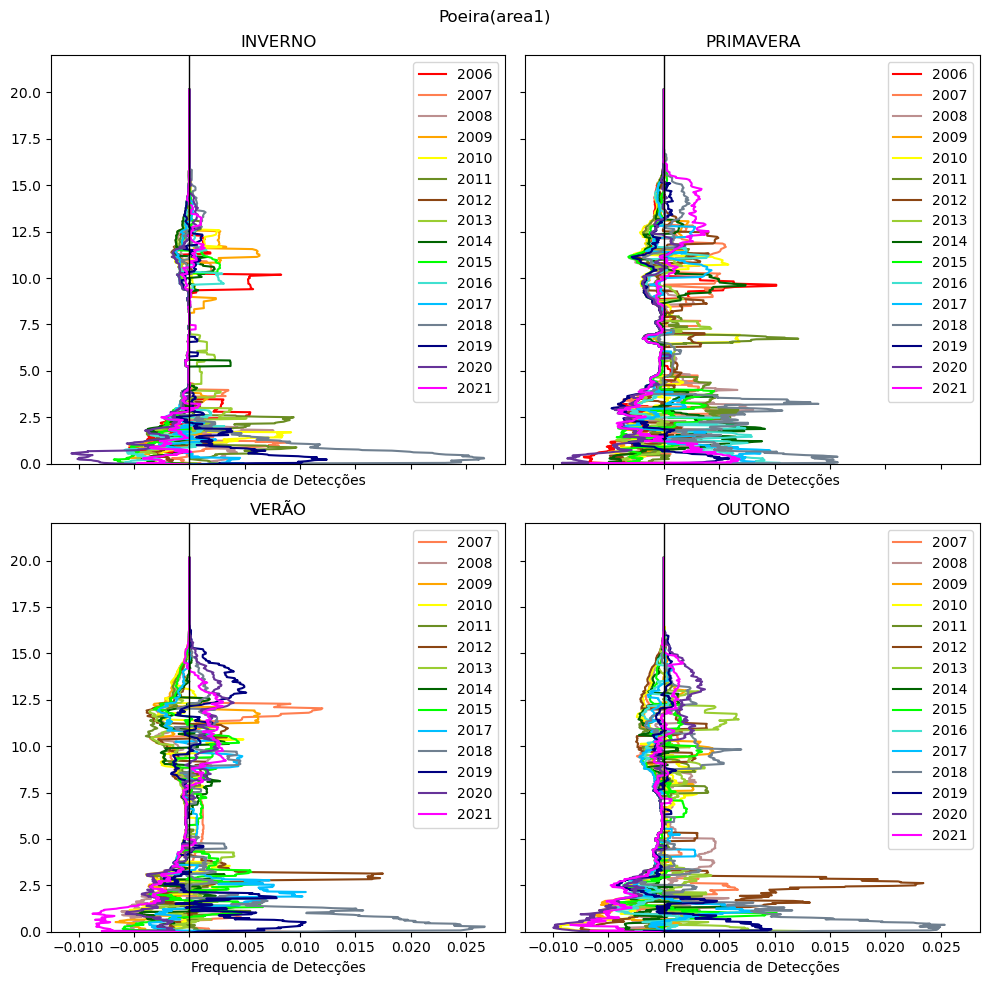

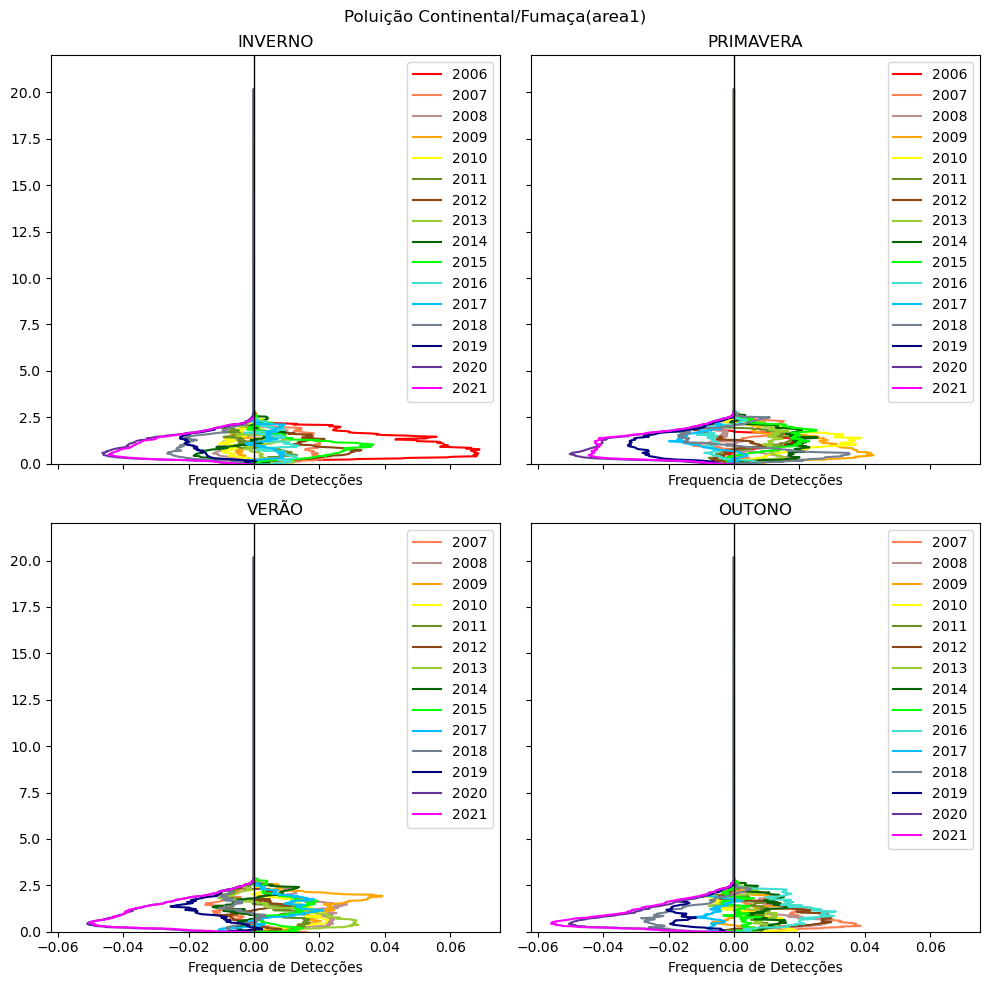

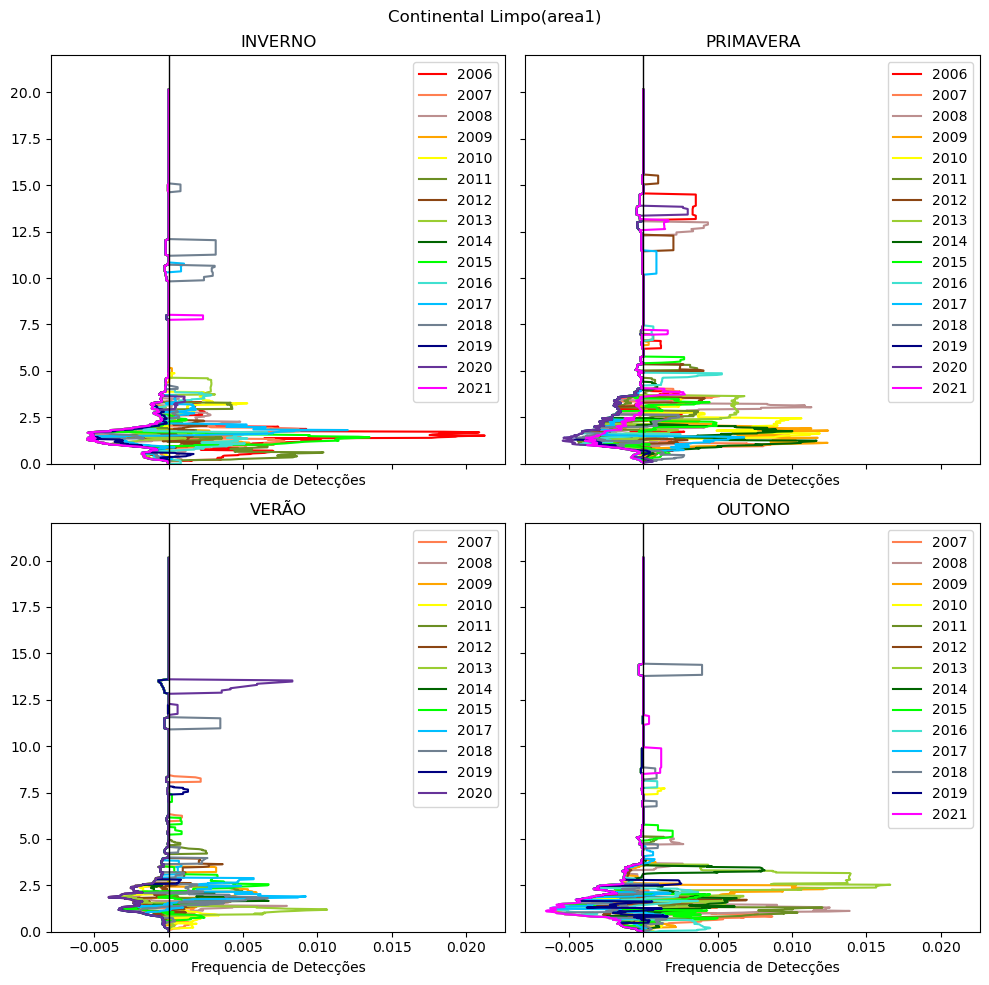

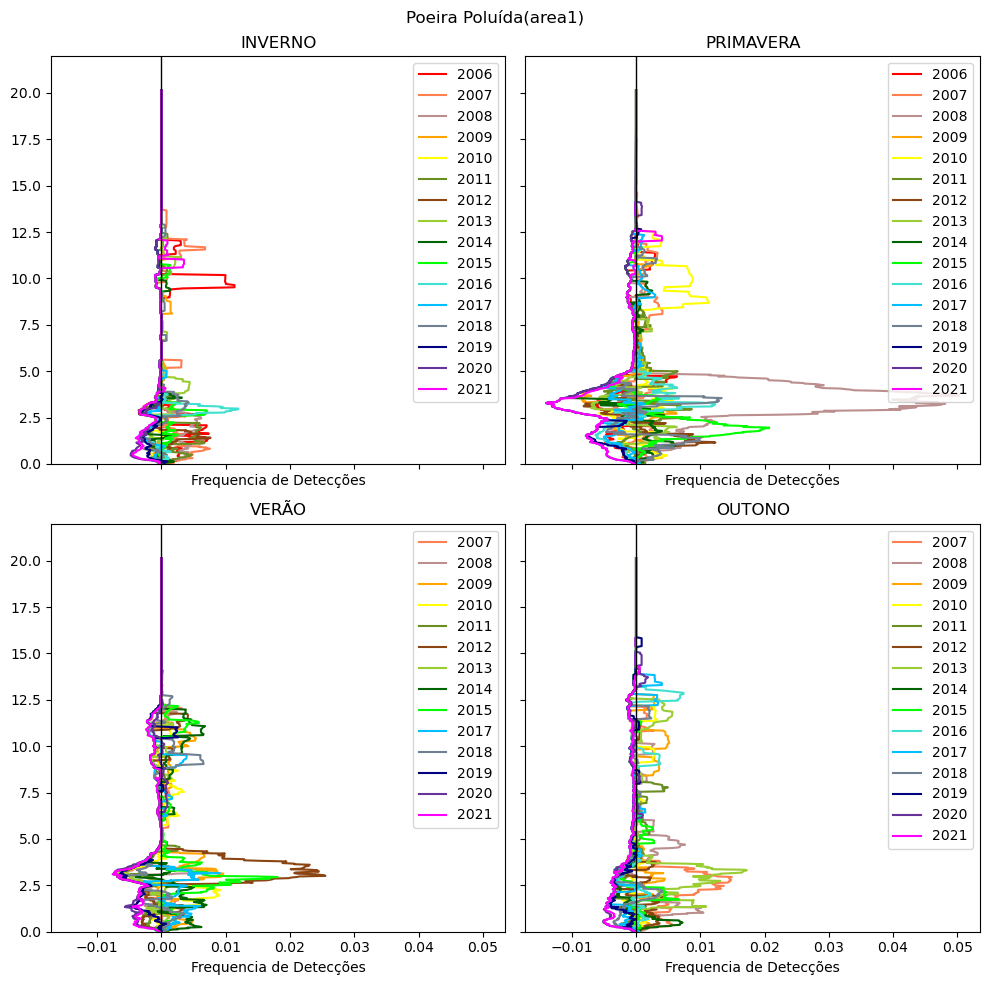

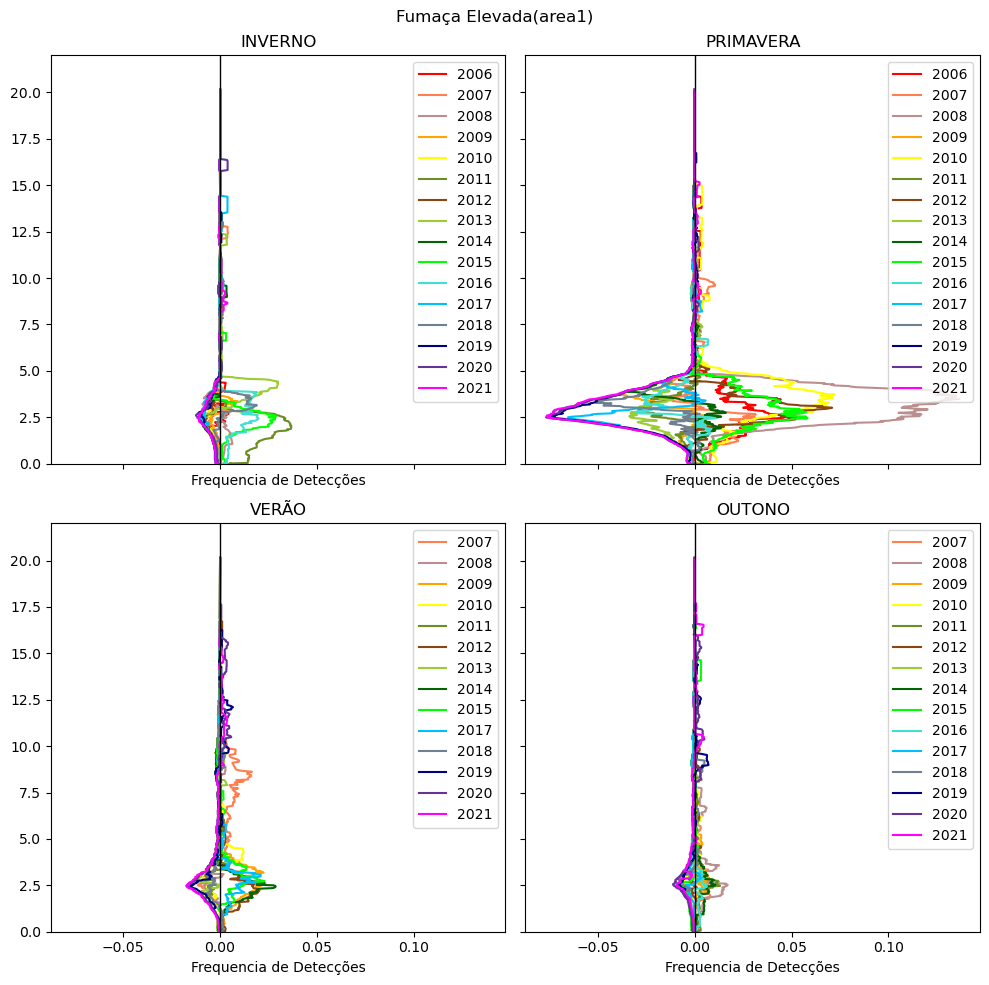

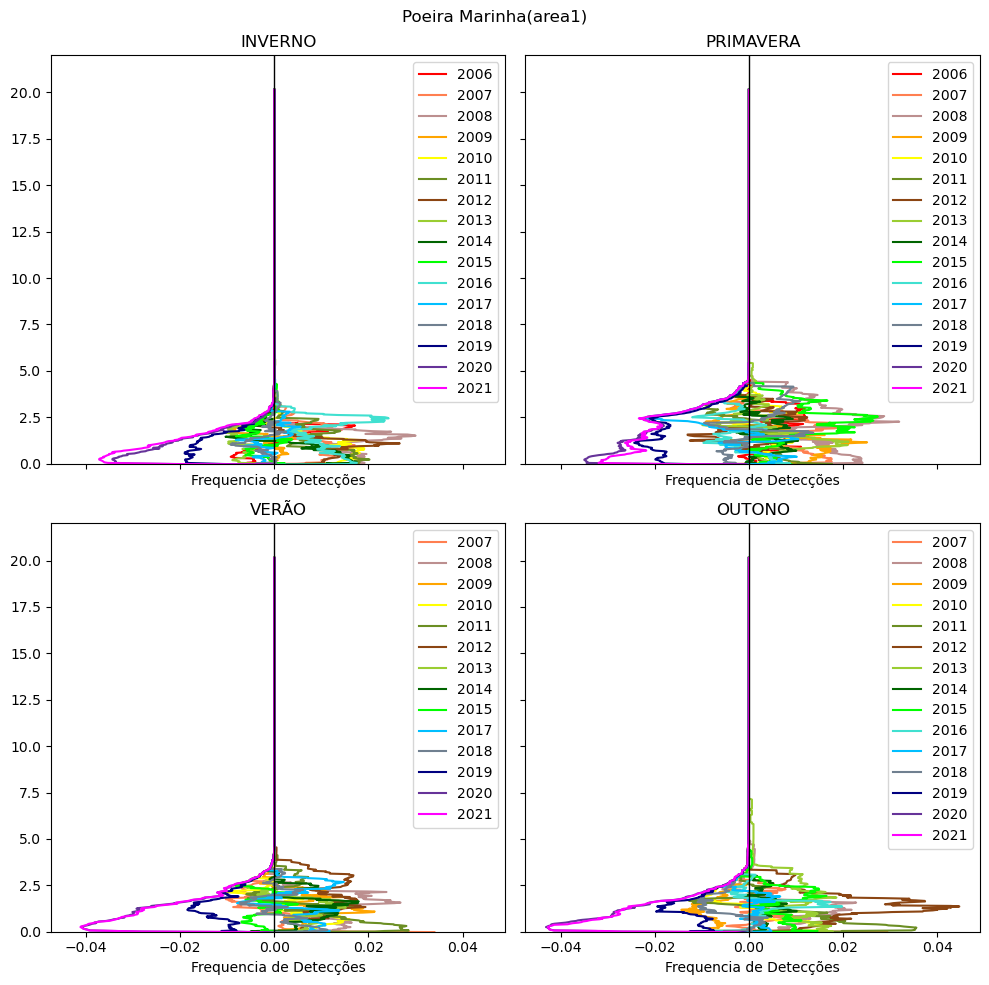


    O mesmo do gráfico de cima para cada tipo de aerossol.



In [77]:
cores = {'2006': 'red', '2007': 'coral', '2008': 'rosybrown', '2009': 'orange',
         '2010': 'yellow', '2011': 'olivedrab', '2012': 'saddlebrown', '2013': 'yellowgreen',
         '2014': 'darkgreen', '2015': 'lime', '2016': 'turquoise', '2017': 'deepskyblue',
         '2018': 'slategrey', '2019': 'navy', '2020': 'rebeccapurple', '2021': 'fuchsia',
         '2022': 'deeppink'}
tipos = ['Marinho Limpo', 'Poeira', 'Poluição Continental/Fumaça',
         'Continental Limpo', 'Poeira Poluída', 'Fumaça Elevada', 'Poeira Marinha']

estacoes = ['INVERNO', 'PRIMAVERA', 'VERÃO', 'OUTONO']
alt_0_8 = [round(-0.5 + x*0.03, 2) for x in range(0,290)]
alt_8_20 = [round(8.2 + x*0.06, 2) for x in range(0,200)]
alt= alt_0_8+alt_8_20

anom_tipo = anomalia_freq.copy().fillna(0)
anom_tipo.columns = anom_tipo.columns.reorder_levels([2, 0, 1])
for tipo in tipos:
    try:
        fig, axs = plt.subplots(2,2,figsize = (10,10), facecolor='white', sharex=True, sharey=True)
        for estacao, ax in zip(estacoes, axs.flatten()):
            anos = anom_tipo[tipo][estacao].columns.unique(level=0)
            ax.set_title(estacao)
            for ano in anos:
                ax.plot(anom_tipo[tipo][estacao][ano], alt, color=cores[ano[-4:]])
    
            ax.axvline(color='black', linewidth=1)
            ax.set_ylim(0, 22)
            ax.set_xlabel('Frequencia de Detecções', fontsize=10)
            ax.legend([x[-4:] for x in anos])
        fig.suptitle(tipo+f"(area{area})")
        fig.tight_layout()
        #plt.savefig(fun_district(path) +'\\' + cidade + '_anomalia_deteccao_tipo' + tipo.replace(' ', '_').replace('/', '_')+f'(area{area})', bbox_inches='tight')
        plt.show()
    except:
        print(f'Não tem a o aerossol do tipo {tipo}')
print('''
    O mesmo do gráfico de cima para cada tipo de aerossol.
''')

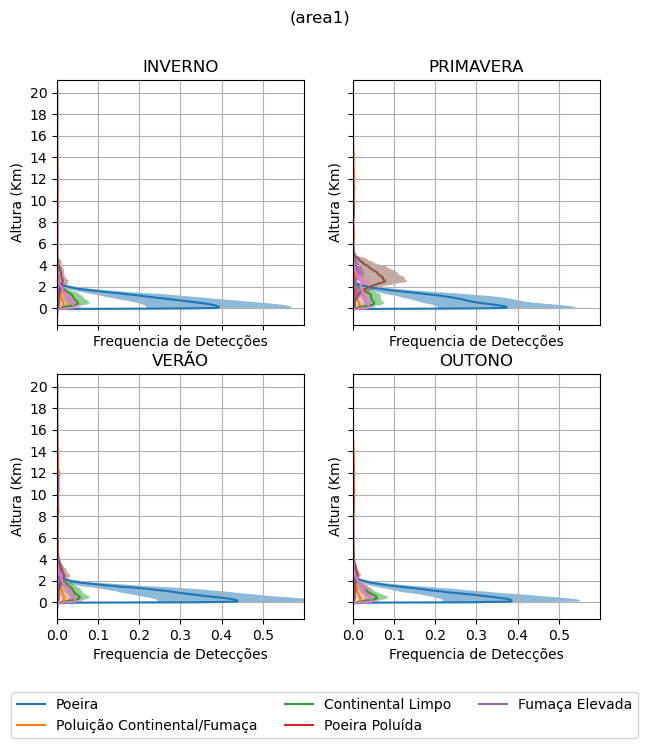


    Média sazonal de cada tipo de aerossol troposférico



In [78]:
# Perfil vertical das detecções sazonais de cada tipo de aerossol
med_detec = med_freq_periodo.reorder_levels([0,2,1], axis = 1).fillna(0)
fig, axs = plt.subplots(2,2,figsize = (7,7), facecolor='white', sharex=True, sharey=True)
estacoes = ['INVERNO', 'PRIMAVERA', 'VERÃO', 'OUTONO']

alt_0_8 = [round(-0.5 + x*0.03, 2) for x in range(0,290)]
alt_8_20 = [round(8.2 + x*0.06, 2) for x in range(0,200)]
alt= alt_0_8+alt_8_20

for estacao,ax in zip(estacoes,axs.flatten()):
    for tipo in med_detec[estacao]['mean'].columns:
        ax.plot(med_detec[estacao]['mean'][tipo],alt, label=tipo)
        ax.fill_betweenx(alt, med_detec[estacao]['mean'][tipo]+med_detec[estacao]['std'][tipo],
        med_detec[estacao]['mean'][tipo]-med_detec[estacao]['std'][tipo], alpha=0.5, label='_nolegend_')
    
    ax.set_xlabel('Frequencia de Detecções', fontsize= 10)
    ax.set_ylabel('Altura (Km)',fontsize= 10)
    ax.set_title(estacao)
    ax.set_xlim(0) 
    # # ax.locator_params(axis = 'x',  min_n_ticks=6)
    # ax.set_xticks(np.arange(0,1000, 150)) 
    ax.set_yticks(np.arange(0,22, 2))
    ax.set_xticks(np.arange(0, 0.6, 0.1))
    ax.grid(True)

#fig.suptitle('MÉDIA DA DETECÇÃO POR TIPO DE AEROSSÓIS TROPOSFÉRICOS\n(JUN/2011- MAI/2016)',fontsize= 10)

lgd = fig.legend(['Poeira', 'Poluição Continental/Fumaça', 'Continental Limpo','Poeira Poluída', 'Fumaça Elevada'],
loc='lower left', bbox_to_anchor=(0.05, -.07),  ncol=3)

#fig.tight_layout()
fig.suptitle(f"(area{area})")
#plt.savefig(fun_district(path) +'\\'+ cidade + f'_media_sazonal_2006_2021_deteccoes_tipo(area{area})', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

print('''
    Média sazonal de cada tipo de aerossol troposférico
''')